## 量子フーリエ変換

qiskitを利用して、量子アルゴリズムについて自分なりに勉強していこうと思います。
個人的な勉強の記録なので、説明などを大幅に省いている可能性があります。

qiskitのウェブサイト通りに勉強を進めています。

- https://qiskit.org/textbook/ja/ch-algorithms/quantum-fourier-transform.html

次は、量子フーリエ変換の復習をしてみます。学生時代に理解したつもりでしたが、全く忘れているので、１から勉強し直しです。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/qiskit/base5/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/qiskit/base5/base_nb.ipynb)

### 筆者の環境

In [53]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G103


In [54]:
!python -V

Python 3.8.5


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.19.2
pandas version : 1.1.3


In [56]:
import qiskit
import json

dict(qiskit.__qiskit_version__)

{'qiskit-terra': '0.17.4',
 'qiskit-aer': '0.8.2',
 'qiskit-ignis': '0.6.0',
 'qiskit-ibmq-provider': '0.13.1',
 'qiskit-aqua': '0.9.1',
 'qiskit': '0.26.2',
 'qiskit-nature': None,
 'qiskit-finance': None,
 'qiskit-optimization': None,
 'qiskit-machine-learning': None}

## 離散フーリエ変換の復習

フーリエ変換は、関数$f(x)$は様々な波数を持つ三角関数の和として表現できるというフーリエの考え方から来ています。

$$
f(x)=\frac{a_{0}}{2}+a_{1} \cos \frac{\pi x}{L}+b_{1} \sin \frac{\pi x}{L}+a_{2} \cos \frac{2 \pi x}{L}+b_{2} \sin \frac{2 \pi x}{L}+\cdots
$$

ここで、　$a_1$や$b_1$などは、それぞれの波数を持つ三角関数の振幅であり、関数＄f(x)＄を三角関数で分解したときの重みと考えられます。これらの振幅を求めるには三角関数の公式を利用して以下の様に求める事が出来ます。

$$
a_{n}=\frac{1}{L} \int_{-L}^{L} f(x) \cos \frac{n \pi x}{L} d x \quad(n=0,1,2, \cdots)
$$

$$
b_{n}=\frac{1}{L} \int_{-L}^{L} f(x) \sin \frac{n \pi x}{L} d x \quad(n=1,2, \cdots)
$$

それぞれの振幅をフーリエ係数と呼ぶようです。

これを$L \rightarrow \infty$としてあげて、$\cos$と$\sin$をオイラー数を用いて変換してあげると、以下の公式が導かれます。

$$
\begin{aligned}
&{F}(k)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} f(x) e^{-i k x} d x \\
&f(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} \hat{F}(k) e^{i k x} d k
\end{aligned}
$$

今関数$f(x)$は連続関数という仮定がありましたが、これを離散化してあげると、

$$
\begin{aligned}
y_{k}=\frac{1}{\sqrt{2^{n}}} \sum_{j=0}^{2^{n}-1} x_{j} \exp \left(i \frac{2 \pi k j}{2^{n}}\right) \\
x_{k}=\frac{1}{\sqrt{2^{n}}} \sum_{j=0}^{2^{n}-1} y_{j} \exp \left(-i \frac{2 \pi k j}{2^{n}}\right) 
\end{aligned}
$$

と変換できます。これは、ベクトル$\left(x_{0}, \ldots, x_{N-1}\right)$からベクトル$\left(y_{0}, \ldots, y_{N-1}\right)$へのマッピングに相当します。

フーリエ変換は実世界では欠かせない技術で、サラリーマン時代、アナログ回路設計や半導体設計をしてきましたが、これなしではデバイスを開発することは出来ません。

## 量子フーリエ変換

先ほどの議論を量子状態の変換に応用します。$|\boldsymbol{x}\rangle$、$|\boldsymbol{y}\rangle$を以下の様な重ね合わせの状態と定義します。

$$
|\boldsymbol{x}\rangle=\sum_{j=0}^{2^{n}-1} x_{j}|j\rangle 
$$

$$
|\boldsymbol{y}\rangle=\sum_{k=0}^{2^{n}-1} y_{k}|k\rangle
$$

$|\boldsymbol{x}\rangle \rightarrow |\boldsymbol{y}\rangle$への変換を考えます。$|\boldsymbol{y}\rangle$は、以下の様に変換できます。

$$
\begin{aligned}
|\boldsymbol{y}\rangle&=\sum_{k=0}^{2^{n}-1} y_{k}|k\rangle \\
&=\frac{1}{\sqrt{2^{n}}} \sum_{k=0}^{2^{n}-1} \sum_{j=0}^{2^{n}-1} x_{j} \exp \left(i \frac{2 \pi k j}{2^{n}}\right)|k\rangle \\
&=\sum_{j=0}^{2^{n}-1} x_{j}\left(\frac{1}{\sqrt{2^{n}}} \sum_{k=0}^{2^{n}-1} \exp \left(i \frac{2 \pi k j}{2^{n}}\right)|k\rangle\right)
\end{aligned}
$$

つまり、

$$
|\boldsymbol{j}\rangle \rightarrow \frac{1}{\sqrt{2^{n}}} \sum_{k=0}^{2^{n}-1} \exp \left(i \frac{2 \pi k j}{2^{n}}\right)|k\rangle
$$

という変換が量子フーリエ変換になることが分かります。一般的にこの$\exp$の部分を

$$
W=w^{k j}=\exp \left(i \frac{2 \pi kj}{2^{n}}\right)
$$

と書き、この$W$は

$$
W^{\dagger} W=W W^{\dagger}=I
$$

を満たすので、量子フーリエ変換はユニタリ変換になります。

$$
\begin{aligned}
& \frac{1}{\sqrt{2^{n}}} \sum_{k=0}^{2^{n}-1} \exp \left(i \frac{2 \pi k j}{2^{n}}\right)|k\rangle \\
&=\frac{1}{\sqrt{2^{n}}} \sum_{k_{1}=0}^{1} \sum_{k_{2}=0}^{1} \cdots \sum_{k_{n}=0}^{1} \exp \left(i \frac{2 \pi j\left(k_{1} k_{2} \cdots k_{n}\right)_{2}}{2^{n}}\right)|k_{1}k_{2} \cdots k_{n}\rangle \\
&=\frac{1}{\sqrt{2^{n}}} \sum_{k_{1}={0}}^1 \sum_{k_{2}=0}^{1} \cdots \sum_{k_{n}=0}^{1} \exp \left(i \cdot 2 \pi j\left(0. k_{1} k_{2} \cdots k_{n}\right)_{2}\right)|k_{1} k_{2} \cdots k_{n}\rangle\\
&=\frac{1}{\sqrt{2^{n}}}\left(\sum_{k_{1}=0}^{1} \exp \left(i \cdot 2 \pi j\left(0. k_{1}\right)_{2}|k_{1}\rangle \right)\right) \otimes\left(\sum_{k_{2}=0}^{1} \exp \left(i \cdot 2 \pi j\left(0.0 k_{2}\right)_{2} \mid k_{2}\rangle\right)\right) \otimes \cdots\\
& \cdots \otimes \left(\sum_{k_{n}=0}^{1} \exp (i \cdot 2 \pi j(0. \underbrace{0 \cdots 0 k_{n}}_{n})|k_{n}\rangle\right)
\end{aligned}
$$

ここで、$(\cdots)_2$は２進数表示である事を示します。また、ケットを２進数表記する際、左側から$k_1,k_2, \cdots k_n$とします。
次に$\displaystyle \Sigma$を展開します。


$$
\begin{aligned}
&\frac{1}{\sqrt{2^{n}}}\left(|0\rangle + \exp \left(i \cdot 2 \pi j (0.1 \right)_{2}|1\rangle\right) \otimes \left(|0\rangle + \exp \left(i \cdot 2 \pi j \left(0.01 \right)\_{2}|1\rangle\right) \right) \otimes \cdots \\
&\cdots \otimes \left(|0\rangle + \exp \left(i \cdot 2 \pi j (0.0 \cdots 1 \right)\_{2}|1\rangle\right)
\end{aligned}
$$

ここで$|j\rangle = |j_{1}j_{2}\cdots j_n\rangle$として、二進数表記すると、以下の様になります。

$$
\begin{aligned}
&\exp\left(2 \pi j(0.1)\_{2}\right)=\exp\left(2 \pi\left(j\_{1} j\_{2} \cdots j\_{n-1}. j\_{n}\right)\_{2}\right)=\exp\left(2 \pi\left(0. j\_{n}\right)\_{2}\right) \\
&\exp\left(2 \pi j(0.01)\_{2}\right)=\exp\left(2 \pi\left(j\_{1} j\_{2} \cdots j\_{n-2} . j\_{n-1} j\_{n}\right)\_{2}\right)=\exp\left(2 \pi\left(0.j\_{n-1} j\_{n}\right)\_{2}\right) \\
&\vdots \\
&\exp\left(2 \pi\_{j}(0.0 \cdots 01)\_{2}\right)=\exp\left(2 \pi\left(0 . j\_{2} \cdots j\_{n-1} j\_{n}\right)\_{2}\right)\\
&\exp\left(2 \pi\_{j}(0.0 \cdots 01)\_{2}\right)=\exp\left(2 \pi\left(0 . j\_{1} j\_{2} \cdots j\_{n-1} j\_{n}\right)\_{2}\right)
\end{aligned}
$$

2$\pi$にかかる整数部分は考えなくても良いことがポイントでしょうか。

計算を進めると、

$$
\begin{aligned}
&\frac{1}{\sqrt{2^{n}}}\left( |0\rangle + \exp \left(i \cdot 2 \pi \cdot 0.j_{n} \right)|1\rangle \right) \otimes \left(|0\rangle + \exp \left(i \cdot 2 \pi \cdot 0.j_{n-1}j_{n} \right)|1\rangle  \right) \otimes \cdots\\
& \cdots \otimes \left(|0\rangle + \exp \left(i \cdot 2 \pi \cdot 0.j_1j_2\cdots j_n \right)|1\rangle  \right) \,\, \cdots \,\, (1)
\end{aligned}
$$

となります。この表現はqiskitのサイトにあるように、

$$
\frac{1}{\sqrt{N}}\left(|0\rangle+e^{\frac{2 \pi i}{2} x}|1\rangle\right) \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2^{2}} x}|1\rangle\right) \otimes \ldots \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2^{n-1}} x}|1\rangle\right) \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2^{n} x}}|1\rangle\right) \,\, \cdots \,\, (2)
$$

と同じです。次は、これをどのように量子回路で表現するかが次のポイントになります。

### 一つ目の回路
一つ目の回路はアダマールゲートです。状態$j$に対して以下の様な作用します。
$$
H\left|j\right\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(\frac{2 \pi i}{2} j\right)|1\rangle\right)
$$

### 二つ目の回路

二つ目がControl-Rotation回路で、コントロールビットに応じて固有値が変化します。CNOTゲートの位相を任意$(2^{-x})$に変更させるゲートになります。

$$
\begin{gathered}
C R O T_{k}\left|0 x_{j}\right\rangle=\left|0 x_{j}\right\rangle \\
C R O T_{k}\left|1 x_{j}\right\rangle=\exp \left(\frac{2 \pi i}{2^{k}} x_{j}\right)\left|1 x_{j}\right\rangle
\end{gathered}
$$

行列で表現すると以下の様になります。

$$
U R O T_{k}=\left[\begin{array}{lc}
1 & 0 \\
0 & \exp \left(\frac{2 \pi i}{2^{k}}\right)
\end{array}\right]
$$

### 量子回路

天下りですがアダマールゲートとCROTゲートを2量子ビットに適用してみます。

$$
\begin{aligned}
CROT_2 \cdot H_1\left|j_1j_2\right\rangle&=CROT_2 \left( \frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(\frac{2 \pi i}{2} j_1 \right)|1\rangle\right)\otimes|j_2\rangle\right) \\
&=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(\frac{2 \pi i}{2}j_1 + \frac{2 \pi i}{2^2} j_2 \right)|1\rangle\otimes|j_2\rangle\right) \\
&=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_1 + i \cdot 2 \pi \cdot 0.0j_2  \right)|1\rangle\otimes|j_2\rangle\right) \\
&=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_1j_2  \right)|1\rangle\otimes|j_2\rangle\right) \\
\end{aligned}
$$

これを$n$ビットに拡張し、CROTゲートも一般化すると、

$$
\begin{aligned}
CROT_n \cdots CROT_2 \cdot H_1\left|j_1j_2\cdots j_n\right\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_1j_2\cdots j_n  \right)|1\rangle\otimes|j_2j_3\cdots j_n\rangle\right) \\
\end{aligned}
$$

この式の第一項は式(1)の最後の項と似ています。
上記ではコントロールビットを第一量子ビットにしましたが、これを第二量子ビット、第三量子ビットに変えて同じような作用を行います。

次にアダマールゲートを第二量子ビットに作用させ、コントロールビットを第二量子ビットにしてCROTゲートを適用すると、

$$
\begin{aligned}
& CROT_n \cdots CROT_2 \cdot H_2 \cdot \frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_1j_2\cdots j_n  \right)|1\rangle\otimes|j_2j_3\cdots j_n\rangle\right) \\
&=\frac{1}{\sqrt{2}}\left(|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_1j_2\cdots j_n  \right)|1\rangle\otimes|0\rangle+\exp \left(i \cdot 2 \pi \cdot 0.j_2\cdots j_n  \right)|1\rangle\otimes|j_3j_4\cdots j_n\rangle\right) \,\, \cdots \,\, (3)\\
\end{aligned}
$$

ここで、$x=j_1j_2\cdots j_n$とすると、

$$
i \cdot 2 \pi \cdot 0.j_1j_2j_3\cdots j_n = \frac{2\pi i}{2^n}x  
$$
$$
i \cdot 2 \pi \cdot 0.j_2j_3\cdots j_n = \frac{2\pi i}{2^{n-1}}x  
$$
$$
i \cdot 2 \pi \cdot 0.j_3\cdots j_n = \frac{2\pi i}{2^{n-2}}x  
$$

と書けるので、(3)の計算をさらに進めると、

$$
\frac{1}{\sqrt{2^n}}\left(|0\rangle+e^{\frac{2 \pi i}{2^n} x}|1\rangle\right) \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2^{n-1}} x}|1\rangle\right) \otimes \ldots \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2^{2}} x}|1\rangle\right) \otimes\left(|0\rangle+e^{\frac{2 \pi i}{2} x}|1\rangle\right)
$$

とかけます。こちら目的の式(2)と比較して、量子ビットの並びが反転していますが、これはスワップゲートを適用すれば良いだけなので、大きな問題ではありません。

すなわち、量子フーリエ変換はアダマールゲートとCROTゲートを組み合わせることで実現できるという事になります。

## qiskitを用いた量子フーリエ変換回路の作成

qiskitを用いて量子フーリエ変換をシミュレートする回路を作って見ようと思います。最も右側のビットに対してアダマールゲートを適用するところから始まります。最後に、スワップゲートを適用して、ビットの状態を交換する必要があります。

In [57]:
qc = QuantumCircuit(3)

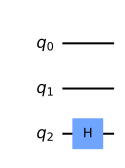

In [58]:
qc.h(2)
qc.draw('mpl')

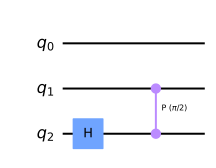

In [59]:
qc.cp(pi/2, 1, 2) # qubit 1 から qubit 2へのCROT 
qc.draw('mpl')

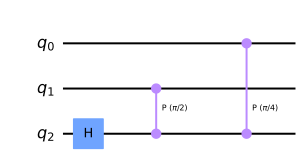

In [60]:
qc.cp(pi/4, 0, 2) # qubit 0から qubit 2へのCROT 
qc.draw('mpl')

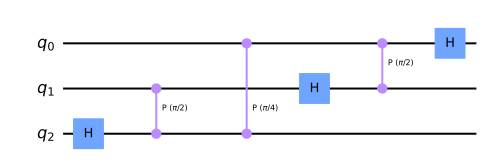

In [61]:
qc.h(1)
qc.cp(pi/2, 0, 1) # qubit 0からqubit 1へのCROT 
qc.h(0)
qc.draw('mpl')

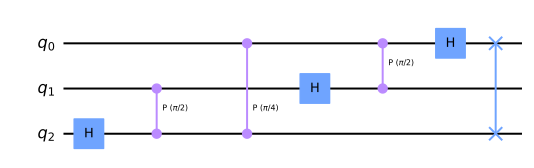

In [62]:
qc.swap(0,2)
qc.draw('mpl')

In [63]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\text{Statevector} = ")

<IPython.core.display.Math object>

## 2量子ビットの場合をqiskitで確認

2ビットにおける量子フーリエ変換を手計算の結果が合っているかqiskitで確認してみます。

In [64]:
from numpy import pi
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex

### 00の場合

$$
\begin{aligned}
\left|00\right\rangle &=\frac{1}{\sqrt{2^{2}}} \sum_{k=0}^{3} \exp \left(i \frac{2 \pi k j}{2^{2}}\right)|k\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{k=0}^{3} |k\rangle \\
&=\frac{1}{2}\left(|00\rangle+|01\rangle+|10\rangle+|11\rangle \right)
\end{aligned}
$$

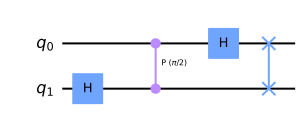

In [65]:
qc = QuantumCircuit(2)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0,1)
qc.draw('mpl')

In [66]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\text{Statevector} = ")

<IPython.core.display.Math object>

となり、一致しています。

### 01の場合

$$
\begin{aligned}
|01\rangle &=\frac{1}{\sqrt{2^{2}}} \sum_{k=1}^{3} \exp \left(i \frac{2 \pi}{2^{2}} k\right)|k\rangle \\
&=\frac{1}{2}\left(|00\rangle+i|01\rangle-|10\rangle-i|11\rangle \right)
\end{aligned}
$$

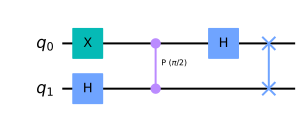

In [67]:
qc = QuantumCircuit(2)
qc.x(0)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0,1)
qc.draw('mpl')

In [68]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\text{Statevector} = ")

<IPython.core.display.Math object>

となり、一致しています。

### 10の場合

$$
\begin{aligned}
|10\rangle &=\frac{1}{\sqrt{2^{2}}} \sum_{k=0}^{3} \exp \left(i \frac{2 \pi \cdot 2}{2^{2}} k\right)|k\rangle \\
&=\frac{1}{2} \sum_{k=0}^{3} \exp (i \pi k)|k\rangle \\
&=\frac{1}{2}\left(|00\rangle-|01\rangle+|10\rangle-|11\rangle\right)
\end{aligned}
$$

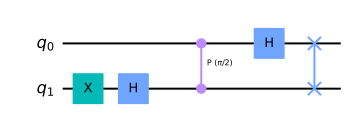

In [69]:
qc = QuantumCircuit(2)
qc.x(1)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0,1)
qc.draw('mpl')

In [70]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\text{Statevector} = ")

<IPython.core.display.Math object>

となり、こちらも一致しています。

### 11の場合

$$
\begin{aligned}
|11 \mid &=\frac{1}{\sqrt{2^{2}}} \sum_{k=0}^{3} \exp \left(i \frac{2 \pi}{2^{2}} 3 k\right)|k\rangle \\
&=\frac{1}{2} \sum_{k=0}^{3} \exp \left(i \frac{3}{2} \pi k\right)|k\rangle \\
&=\frac{1}{2}\left(|00\rangle-i|01\rangle-|10\rangle+i|11\rangle \right)
\end{aligned}
$$

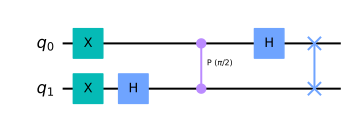

In [71]:
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0,1)
qc.draw('mpl')

In [72]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\text{Statevector} = ")

<IPython.core.display.Math object>

以上より、手計算の結果が確認出来ました。

## 計算量について
随時参考にしている、嶋田先生の著書、[量子コンピューティング: 基本アルゴリズムから量子機械学習まで](
https://www.amazon.co.jp/%E9%87%8F%E5%AD%90%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0-%E5%9F%BA%E6%9C%AC%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%8B%E3%82%89%E9%87%8F%E5%AD%90%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%BE%E3%81%A7-%E6%83%85%E5%A0%B1%E5%87%A6%E7%90%86%E5%AD%A6%E4%BC%9A%E5%87%BA%E7%89%88%E5%A7%94%E5%93%A1%E4%BC%9A/dp/4274226212#:~:text=OK-,%E9%87%8F%E5%AD%90%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%3A%20%E5%9F%BA%E6%9C%AC%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%8B%E3%82%89%E9%87%8F%E5%AD%90%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92,%E5%8D%98%E8%A1%8C%E6%9C%AC%20%E2%80%93%202020%2F11%2F9&text=%E3%81%93%E3%82%8C%E3%81%8B%E3%82%89%E5%BF%85%E3%81%9A%E3%81%8F%E3%82%8B%E9%87%8F%E5%AD%90%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%83%86,%E3%82%84%E3%81%99%E3%81%8F%E8%A7%A3%E8%AA%AC%E3%81%97%E3%81%9F%E6%9B%B8%E7%B1%8D%E3%81%A7%E3%81%99%E3%80%82)によりますと、FFTの計算量が$O(N\log N)$で量子フーリエ変換の計算量が$O((\log N)^2)$なので、一見量子フーリエ変換の高速に見えますが、実行や測定の手間を考えると必ずしも量子フーリエ変換にアドバンテージがあるとは限らないようです。とは言え、最初に考えた人天才ですね。ただただ感嘆するばかりです。